In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download andrewmvd/drive-digital-retinal-images-for-vessel-extraction


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction
License(s): other
drive-digital-retinal-images-for-vessel-extraction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip drive-digital-retinal-images-for-vessel-extraction.zip

Archive:  drive-digital-retinal-images-for-vessel-extraction.zip
replace DRIVE/test/images/01_test.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DRIVE/test/images/01_test.tif  
  inflating: DRIVE/test/images/02_test.tif  
  inflating: DRIVE/test/images/03_test.tif  
  inflating: DRIVE/test/images/04_test.tif  
  inflating: DRIVE/test/images/05_test.tif  
  inflating: DRIVE/test/images/06_test.tif  
  inflating: DRIVE/test/images/07_test.tif  
  inflating: DRIVE/test/images/08_test.tif  
  inflating: DRIVE/test/images/09_test.tif  
  inflating: DRIVE/test/images/10_test.tif  
  inflating: DRIVE/test/images/11_test.tif  
  inflating: DRIVE/test/images/12_test.tif  
  inflating: DRIVE/test/images/13_test.tif  
  inflating: DRIVE/test/images/14_test.tif  
  inflating: DRIVE/test/images/15_test.tif  
  inflating: DRIVE/test/images/16_test.tif  
  inflating: DRIVE/test/images/17_test.tif  
  inflating: DRIVE/test/images/18_test.tif  
  inflating: DRIVE/test/images/19_test.tif  
 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects, disk, opening
from skimage.measure import label
from skimage.metrics import adapted_rand_error
from glob import glob
from tqdm import tqdm
import time

In [ ]:
DATASET_PATH = "/content/DRIVE/training"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZES = [15, 25]
#K_VALUES = [-0.2, -0.3]

In [ ]:
def load_drive():
    images = sorted(glob(DATASET_PATH + "/images/*.tif"))
    gts = sorted(glob(DATASET_PATH + "/1st_manual/*.gif"))
    masks = sorted(glob(DATASET_PATH + "/mask/*.gif"))

    print("Images:", len(images), "GT:", len(gts), "Masks:", len(masks))

    if len(images) == 0:
        raise ValueError("Dataset path is wrong")

    return images, gts, masks

In [ ]:
def preprocess(path):
    img = cv2.imread(path)
    green = img[:, :, 1]

    clahe = cv2.createCLAHE(2.0, (8,8))
    enhanced = clahe.apply(green)

    # Reduce blur to a 3x3 kernel to preserve thin vessels
    blur = cv2.GaussianBlur(enhanced, (3,3), 0)

    # Use Black-Hat to extract dark vessels from the bright background.
    # This automatically returns bright vessels on a dark background.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, kernel)

    return blackhat.astype(np.float32)

In [ ]:
def local_mean_std(img, w):

    mean = cv2.boxFilter(img, cv2.CV_32F, (w, w))
    sqmean = cv2.boxFilter(img * img, cv2.CV_32F, (w, w))

    var = sqmean - mean * mean
    var[var < 0] = 0
    std = np.sqrt(var)

    return mean, std

In [ ]:
# Update constants to positive margins
K_VALUES = [0.1, 0.2, 0.3]

def niblack(img, w, k):
    m, s = local_mean_std(img, w)
    # Threshold ABOVE the mean for bright vessels
    T = m + k * s
    return (img > T).astype(np.uint8)

def sauvola(img, w, k):
    m, s = local_mean_std(img, w)
    R = np.max(s) + 1e-8
    # Modified Sauvola formula for bright objects.
    # Subtracting the negative (s/R - 1) term ensures T > m.
    T = m * (1 - k * ((s / R) - 1))
    return (img > T).astype(np.uint8)

In [ ]:
def postprocess(mask):
    # Just clean up small disconnected noise blobs without eroding continuous thin vessels
    cleaned = remove_small_objects(mask.astype(bool), min_size=20)
    return cleaned.astype(np.uint8)

In [ ]:
def thin_vessel_mask(gt):

    dist = cv2.distanceTransform(gt, cv2.DIST_L2, 5)
    thin = dist <= 1
    return thin.astype(np.uint8)


In [ ]:
def metrics(pred, gt):

    TP = np.sum((pred == 1) & (gt == 1))
    TN = np.sum((pred == 0) & (gt == 0))
    FP = np.sum((pred == 1) & (gt == 0))
    FN = np.sum((pred == 0) & (gt == 1))

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    sens = TP / (TP + FN + 1e-8)
    spec = TN / (TN + FP + 1e-8)
    prec = TP / (TP + FP + 1e-8)
    f1 = 2 * prec * sens / (prec + sens + 1e-8)

    return acc, sens, spec, f1

def thin_sensitivity(pred, thin_gt):
    TP = np.sum((pred == 1) & (thin_gt == 1))
    FN = np.sum((pred == 0) & (thin_gt == 1))
    return TP / (TP + FN + 1e-8)

In [ ]:
def run():

    images, gts, masks = load_drive()

    rows = []

    for img_p, gt_p, mask_p in tqdm(zip(images, gts, masks), total=len(images)):

        img = preprocess(img_p)

        gt = cv2.imread(gt_p, 0) // 255
        fov = cv2.imread(mask_p, 0) // 255

        thin_gt = thin_vessel_mask(gt)

        img = img * fov   # mask BEFORE thresholding

        for w in WINDOW_SIZES:
            for k in K_VALUES:

                for name, func in [("niblack", niblack), ("sauvola", sauvola)]:

                    start = time.time()

                    pred = func(img, w, k)
                    pred = postprocess(pred)
                    pred = pred * fov

                    print("Foreground pixels:", np.sum(pred))

                    acc, sens, spec, f1 = metrics(pred, gt)
                    thin = thin_sensitivity(pred, thin_gt)

                    rows.append([name, w, k, acc, sens, spec, f1, thin, time.time()-start])

    df = pd.DataFrame(rows, columns=[
        "Method","Window","k","Accuracy","Sensitivity",
        "Specificity","F1","Thin_Sensitivity","Time"
    ])

    df.to_csv(RESULTS_DIR + "/metrics.csv", index=False)
    return df

In [ ]:
def show_sample():

    images, gts, masks = load_drive()

    img = preprocess(images[0])
    gt = cv2.imread(gts[0], 0) // 255
    fov = cv2.imread(masks[0], 0) // 255 # Load fov mask
    img_masked = img * fov # Mask the image once here

    # Use k=0.2 for consistency with K_VALUES in run()
    nibl = postprocess(niblack(img_masked, 25, 0.2))
    sauv = postprocess(sauvola(img_masked, 25, 0.2))
    thin = thin_vessel_mask(gt)

    # Apply fov mask to the predictions for visualization too
    nibl = nibl * fov
    sauv = sauv * fov

    plt.figure(figsize=(15,6))

    plt.subplot(1,5,1); plt.imshow(img_masked, cmap="gray"); plt.title("Preprocessed & Masked") # Show masked preprocessed image
    plt.subplot(1,5,2); plt.imshow(gt, cmap="gray"); plt.title("GT")
    plt.subplot(1,5,3); plt.imshow(nibl, cmap="gray"); plt.title("Niblack (k=0.2)") # Update title
    plt.subplot(1,5,4); plt.imshow(sauv, cmap="gray"); plt.title("Sauvola (k=0.2)") # Update title
    plt.subplot(1,5,5); plt.imshow(thin, cmap="gray"); plt.title("Thin GT")

    plt.show()

Images: 20 GT: 20 Masks: 20


  0%|          | 0/20 [00:00<?, ?it/s]

Foreground pixels: 79158
Foreground pixels: 77694
Foreground pixels: 70825
Foreground pixels: 67784
Foreground pixels: 63101
Foreground pixels: 58390
Foreground pixels: 72978


  5%|▌         | 1/20 [00:00<00:04,  4.14it/s]

Foreground pixels: 72895
Foreground pixels: 65026
Foreground pixels: 64501
Foreground pixels: 57992
Foreground pixels: 57110
Foreground pixels: 77677
Foreground pixels: 77128
Foreground pixels: 70024
Foreground pixels: 68466
Foreground pixels: 62714
Foreground pixels: 60173


 10%|█         | 2/20 [00:00<00:03,  5.73it/s]

Foreground pixels: 71475
Foreground pixels: 72363
Foreground pixels: 64205
Foreground pixels: 65663
Foreground pixels: 57783
Foreground pixels: 59363


 15%|█▌        | 3/20 [00:00<00:02,  6.49it/s]

Foreground pixels: 86560
Foreground pixels: 86667
Foreground pixels: 78930
Foreground pixels: 79176
Foreground pixels: 72217
Foreground pixels: 72230
Foreground pixels: 83233
Foreground pixels: 84655
Foreground pixels: 76250
Foreground pixels: 78872
Foreground pixels: 69791
Foreground pixels: 73230
Foreground pixels: 76875
Foreground pixels: 76333
Foreground pixels: 69529
Foreground pixels: 68422
Foreground pixels: 62706
Foreground pixels: 60539
Foreground pixels: 69945
Foreground pixels: 70602
Foreground pixels: 63262


 20%|██        | 4/20 [00:00<00:02,  6.95it/s]

Foreground pixels: 64517
Foreground pixels: 57379
Foreground pixels: 58740
Foreground pixels: 84359
Foreground pixels: 82036
Foreground pixels: 75686
Foreground pixels: 70714
Foreground pixels: 67661
Foreground pixels: 59926
Foreground pixels: 78021
Foreground pixels: 77306
Foreground pixels: 70247


 25%|██▌       | 5/20 [00:00<00:02,  7.26it/s]

Foreground pixels: 68099
Foreground pixels: 62378
Foreground pixels: 59517
Foreground pixels: 84718
Foreground pixels: 82754
Foreground pixels: 76476
Foreground pixels: 72296


 30%|███       | 6/20 [00:00<00:01,  7.45it/s]

Foreground pixels: 68197
Foreground pixels: 62184
Foreground pixels: 79806
Foreground pixels: 79556
Foreground pixels: 71895
Foreground pixels: 70898
Foreground pixels: 64160
Foreground pixels: 62451
Foreground pixels: 80265
Foreground pixels: 78789
Foreground pixels: 71987
Foreground pixels: 69072


 35%|███▌      | 7/20 [00:01<00:01,  7.45it/s]

Foreground pixels: 64389
Foreground pixels: 59909
Foreground pixels: 74169
Foreground pixels: 74339
Foreground pixels: 66130
Foreground pixels: 65972
Foreground pixels: 59273
Foreground pixels: 59388
Foreground pixels: 79354
Foreground pixels: 78537
Foreground pixels: 71643
Foreground pixels: 69708
Foreground pixels: 64017
Foreground pixels: 61079
Foreground pixels: 72771
Foreground pixels: 73477
Foreground pixels: 64835
Foreground pixels: 65703
Foreground pixels: 57977


 40%|████      | 8/20 [00:01<00:01,  7.47it/s]

Foreground pixels: 58822
Foreground pixels: 82547
Foreground pixels: 81447
Foreground pixels: 74491
Foreground pixels: 72105
Foreground pixels: 66733
Foreground pixels: 63148
Foreground pixels: 77223
Foreground pixels: 77576
Foreground pixels: 69719


 45%|████▌     | 9/20 [00:01<00:01,  7.58it/s]

Foreground pixels: 69801
Foreground pixels: 62430
Foreground pixels: 62760
Foreground pixels: 82133
Foreground pixels: 80732
Foreground pixels: 73469
Foreground pixels: 70640
Foreground pixels: 65475


 50%|█████     | 10/20 [00:01<00:01,  7.64it/s]

Foreground pixels: 61151
Foreground pixels: 76417
Foreground pixels: 76266
Foreground pixels: 68242
Foreground pixels: 67725
Foreground pixels: 61074
Foreground pixels: 60141
Foreground pixels: 82160
Foreground pixels: 81322
Foreground pixels: 74489


 55%|█████▌    | 11/20 [00:01<00:01,  7.71it/s]

Foreground pixels: 72251
Foreground pixels: 67008
Foreground pixels: 63231
Foreground pixels: 77677
Foreground pixels: 77972
Foreground pixels: 69880
Foreground pixels: 70432
Foreground pixels: 62999
Foreground pixels: 63200


 60%|██████    | 12/20 [00:01<00:01,  7.78it/s]

Foreground pixels: 79609
Foreground pixels: 78676
Foreground pixels: 71848
Foreground pixels: 69665
Foreground pixels: 64384
Foreground pixels: 60588
Foreground pixels: 73574
Foreground pixels: 73969
Foreground pixels: 65953
Foreground pixels: 66203
Foreground pixels: 59092
Foreground pixels: 59225
Foreground pixels: 80786
Foreground pixels: 80156
Foreground pixels: 72480
Foreground pixels: 70576
Foreground pixels: 64429
Foreground pixels: 62453
Foreground pixels: 73069
Foreground pixels: 73805
Foreground pixels: 65390


 65%|██████▌   | 13/20 [00:01<00:00,  7.82it/s]

Foreground pixels: 66744
Foreground pixels: 58789
Foreground pixels: 60214
Foreground pixels: 84973
Foreground pixels: 85088
Foreground pixels: 77634
Foreground pixels: 77578
Foreground pixels: 70449
Foreground pixels: 70367
Foreground pixels: 83430
Foreground pixels: 84846
Foreground pixels: 76721


 70%|███████   | 14/20 [00:01<00:00,  7.91it/s]

Foreground pixels: 79119
Foreground pixels: 69986
Foreground pixels: 73606
Foreground pixels: 81039
Foreground pixels: 80000
Foreground pixels: 72971
Foreground pixels: 70380


 75%|███████▌  | 15/20 [00:02<00:00,  7.91it/s]

Foreground pixels: 65345
Foreground pixels: 61700
Foreground pixels: 73758
Foreground pixels: 74265
Foreground pixels: 66417
Foreground pixels: 66963
Foreground pixels: 59711
Foreground pixels: 60000
Foreground pixels: 79812
Foreground pixels: 79323
Foreground pixels: 71998
Foreground pixels: 70123
Foreground pixels: 64615
Foreground pixels: 62381
Foreground pixels: 73087
Foreground pixels: 74029
Foreground pixels: 65955
Foreground pixels: 67212
Foreground pixels: 59107
Foreground pixels: 60700


 85%|████████▌ | 17/20 [00:02<00:00,  7.76it/s]

Foreground pixels: 80686
Foreground pixels: 79441
Foreground pixels: 72156
Foreground pixels: 70162
Foreground pixels: 64350
Foreground pixels: 61064
Foreground pixels: 73194
Foreground pixels: 74056
Foreground pixels: 65532
Foreground pixels: 66564
Foreground pixels: 58539
Foreground pixels: 59906
Foreground pixels: 81018
Foreground pixels: 80017
Foreground pixels: 73032
Foreground pixels: 70981
Foreground pixels: 65518
Foreground pixels: 62546
Foreground pixels: 75393
Foreground pixels: 75859
Foreground pixels: 67851


 90%|█████████ | 18/20 [00:02<00:00,  7.72it/s]

Foreground pixels: 68540
Foreground pixels: 60797
Foreground pixels: 61615
Foreground pixels: 79043
Foreground pixels: 78365
Foreground pixels: 70808
Foreground pixels: 69172
Foreground pixels: 63622
Foreground pixels: 60690
Foreground pixels: 72094
Foreground pixels: 72518
Foreground pixels: 64476


 95%|█████████▌| 19/20 [00:02<00:00,  7.75it/s]

Foreground pixels: 65295
Foreground pixels: 58195
Foreground pixels: 58802
Foreground pixels: 79550
Foreground pixels: 78471
Foreground pixels: 71391


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

Foreground pixels: 68682
Foreground pixels: 64068
Foreground pixels: 59900
Foreground pixels: 71952
Foreground pixels: 72338
Foreground pixels: 64248
Foreground pixels: 64837
Foreground pixels: 57704
Foreground pixels: 58087

===== MEAN PERFORMANCE =====

         Window    k  Accuracy  Sensitivity  Specificity        F1  \
Method                                                               
niblack    20.0  0.2  0.844319     0.838861     0.845191  0.482182   
sauvola    20.0  0.2  0.849161     0.852572     0.849194  0.494370   

         Thin_Sensitivity      Time  
Method                               
niblack          0.181959  0.008899  
sauvola          0.178946  0.009247  
Images: 20 GT: 20 Masks: 20


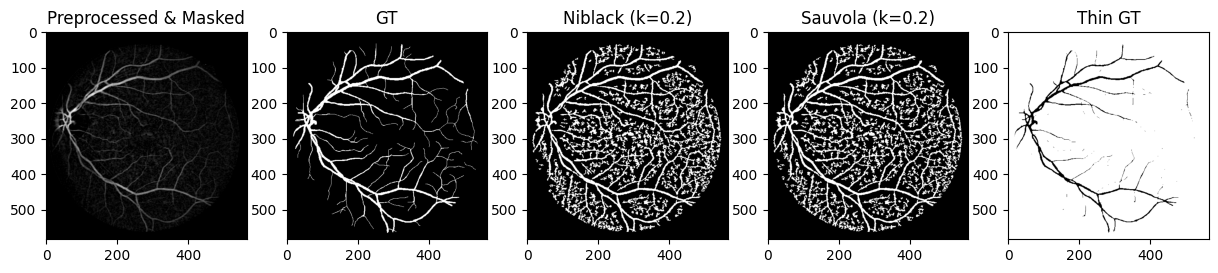

In [ ]:
df = run()

print("\n===== MEAN PERFORMANCE =====\n")
print(df.groupby("Method").mean())

show_sample()